In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ARDL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from google.colab import files
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller

Step 1: Load Data and Check stationarity

ADF Statistic for BP: -16.942488424042597
p-value: 9.594198520432785e-30
BP is stationary after differencing (reject null hypothesis of unit root).




<Figure size 1200x500 with 0 Axes>

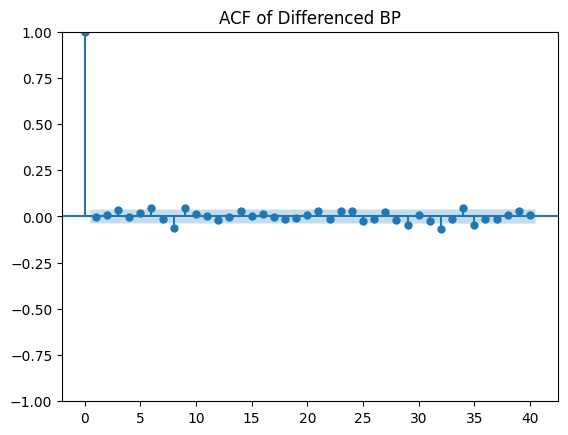

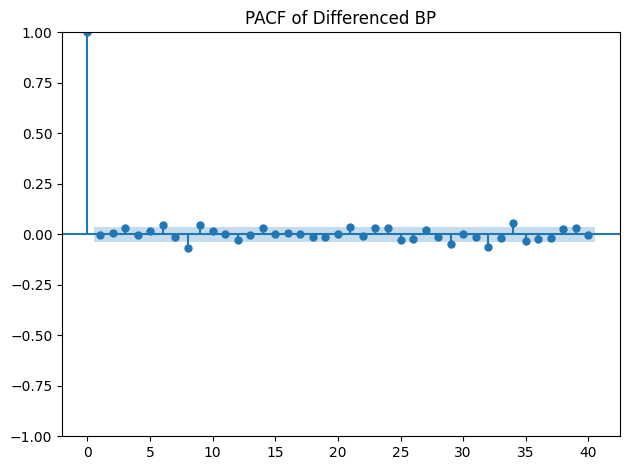

ADF Statistic for CVX: -15.189698100713148
p-value: 6.034784604502326e-28
CVX is stationary after differencing (reject null hypothesis of unit root).




<Figure size 1200x500 with 0 Axes>

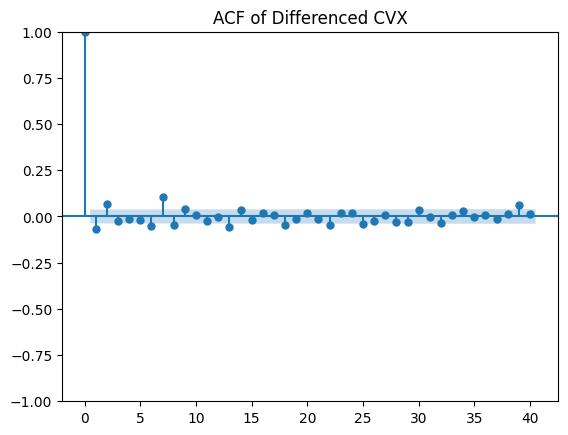

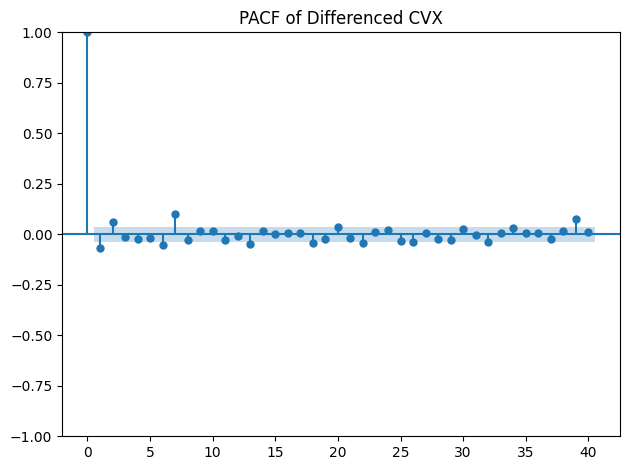

ADF Statistic for EQNR: -54.27135636981621
p-value: 0.0
EQNR is stationary after differencing (reject null hypothesis of unit root).




<Figure size 1200x500 with 0 Axes>

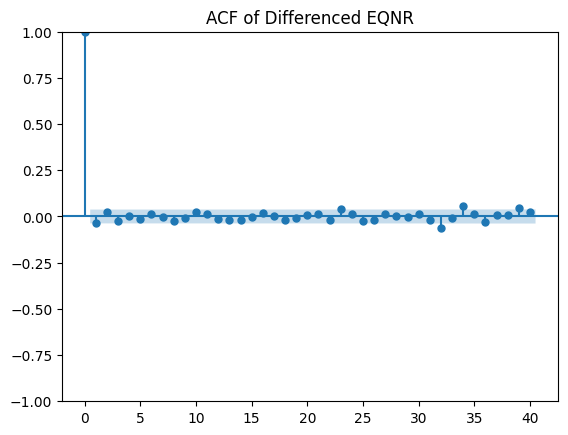

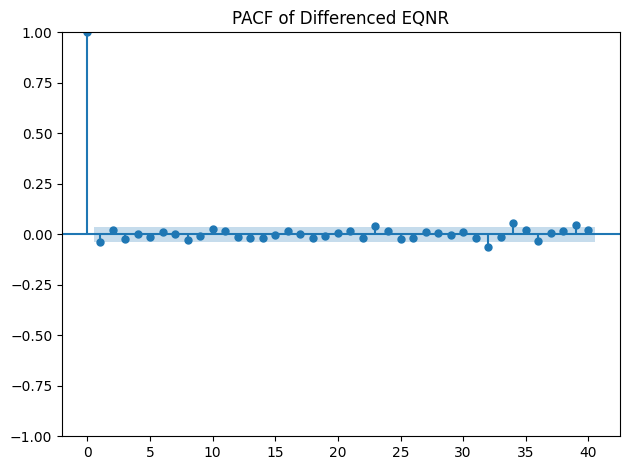

ADF Statistic for OXY: -21.51757885775329
p-value: 0.0
OXY is stationary after differencing (reject null hypothesis of unit root).




<Figure size 1200x500 with 0 Axes>

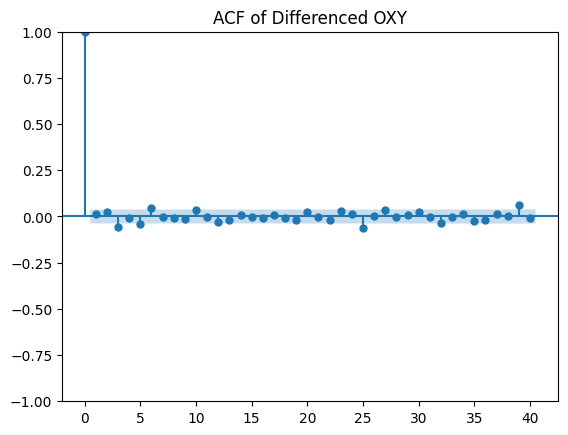

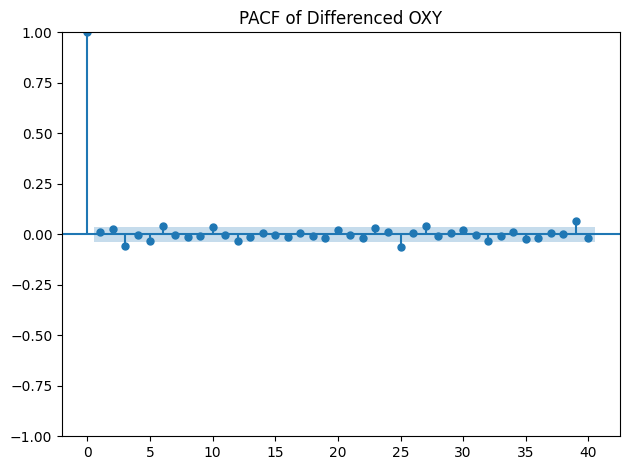

ADF Statistic for SHEL: -16.073969186220047
p-value: 5.468561931134972e-29
SHEL is stationary after differencing (reject null hypothesis of unit root).




<Figure size 1200x500 with 0 Axes>

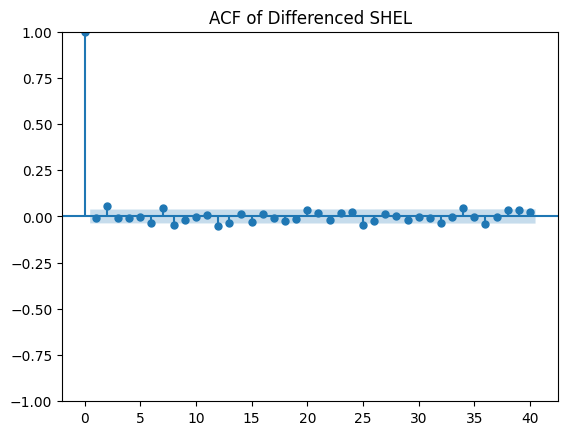

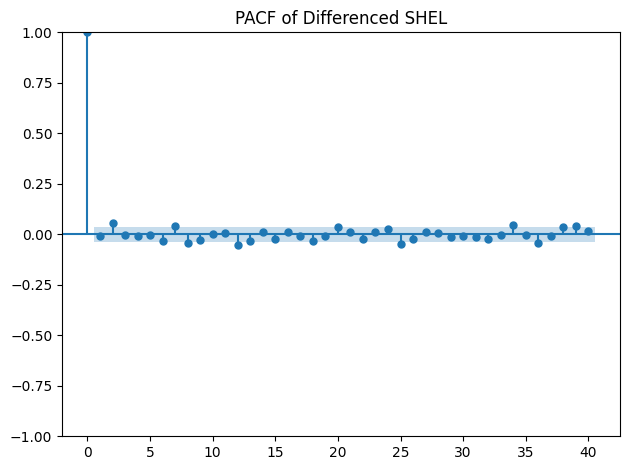

ADF Statistic for XOM: -30.808545174915242
p-value: 0.0
XOM is stationary after differencing (reject null hypothesis of unit root).




<Figure size 1200x500 with 0 Axes>

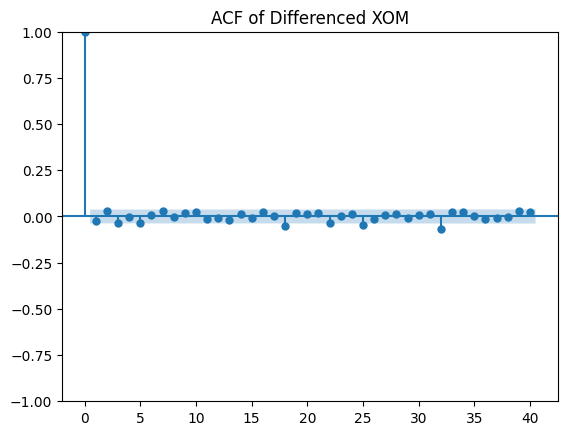

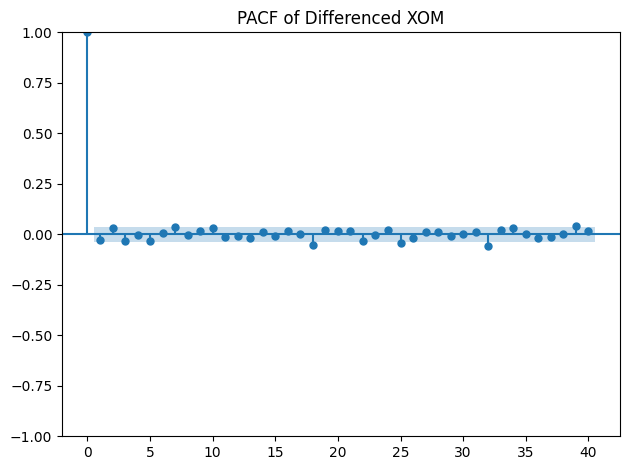

In [ ]:
train_data = pd.read_csv('../../data/processed-data/train_data.csv')
test_data = pd.read_csv('../../data/processed-data/test_data.csv')

filtered_train_data = train_data[~train_data['symbol'].isin(['CL1', 'NG1'])]
filtered_test_data = test_data[~test_data['symbol'].isin(['CL1', 'NG1'])]

train_df = filtered_train_data.pivot(index='date', columns='symbol', values='close')
train_df.index = pd.to_datetime(train_df.index)
test_df = filtered_test_data.pivot(index='date', columns='symbol', values='close')
test_df.index = pd.to_datetime(test_df.index)

symbols = train_df.columns.unique()

# Create differenced datasets for stationarity check and ACF/PACF plots
diff_train_df = train_df.diff().dropna()

# Check stationarity and plot ACF/PACF for differenced series
def check_stationarity_and_plot_acf_pacf(diff_df, original_df, lags=40):
    for symbol in symbols:
        diff_series = diff_df[symbol].dropna()
        adf_result = adfuller(diff_series)
        print(f"ADF Statistic for {symbol}: {adf_result[0]}")
        print(f"p-value: {adf_result[1]}")
        if adf_result[1] <= 0.05:
            print(f"{symbol} is stationary after differencing (reject null hypothesis of unit root).")
        else:
            print(f"{symbol} is still non-stationary (fail to reject null hypothesis of unit root).")
        print("\n")

        # Plot ACF and PACF for differenced series
        plt.figure(figsize=(12, 5))
        plot_acf(diff_series, lags=lags, title=f'ACF of Differenced {symbol}')
        plot_pacf(diff_series, lags=lags, title=f'PACF of Differenced {symbol}')
        plt.tight_layout()
        plt.show()

check_stationarity_and_plot_acf_pacf(diff_train_df, train_df)



Step 2: Find the optimal lag value for covariates using AIC value 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ARDL
from sklearn.metrics import mean_absolute_error
import numpy as np

train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

filtered_train_data = train_data[~train_data['symbol'].isin(['CL1', 'NG1'])]
filtered_test_data = test_data[~test_data['symbol'].isin(['CL1', 'NG1'])]

train_df = filtered_train_data.pivot(index='date', columns='symbol', values='close')
train_df.index = pd.to_datetime(train_df.index)
test_df = filtered_test_data.pivot(index='date', columns='symbol', values='close')
test_df.index = pd.to_datetime(test_df.index)

symbols = train_df.columns.unique()

def find_optimal_order(symbol, train_endog, train_exog, max_order=5):
    min_aic = np.inf
    best_order = None
    best_model = None

    for order in range(1, max_order + 1):
        try:
            # Lag the exogenous variables by the specified order
            train_exog_lagged = train_exog.shift(order).dropna()

            # Align the endogenous variable by trimming its initial rows
            # to match the lagged exogenous variable's length
            train_endog_aligned = train_endog.iloc[-len(train_exog_lagged):].reset_index(drop=True)
            train_exog_aligned = train_exog_lagged.reset_index(drop=True)

            # Fit the ARDL model with endogenous lag fixed at 1 and current exogenous order
            ardl_model = ARDL(train_endog_aligned, lags=1, exog=train_exog_aligned, trend='c', order=order)
            model_fit = ardl_model.fit()

            aic = model_fit.aic
            print(f"Order {order} AIC: {aic}")

            if aic < min_aic:
                min_aic = aic
                best_order = order
                best_model = model_fit
        except Exception as e:
            print(f"Could not fit model for order {order}: {e}")

    print(f"\nOptimal order for {symbol}: {best_order} with AIC: {min_aic}")
    return best_model, best_order, min_aic

# Iterate over each stock symbol and find the optimal order
for symbol in symbols:
    print(f"\nProcessing stock: {symbol}")

    train_endog = train_df[symbol].dropna()
    train_exog = filtered_train_data[filtered_train_data['symbol'] == symbol][['momentum', '30day_STD','30day_SMA']].dropna()

    # Find the optimal order for the exogenous variables
    best_model, best_order, best_aic = find_optimal_order(symbol, train_endog, train_exog)

    if best_model:
        print(f"\nBest model for {symbol} (Order {best_order}): AIC = {best_aic}")
        print(best_model.summary())


Processing stock: BP
Order 1 AIC: 5578.816282412224
Order 2 AIC: 5564.173779617994
Order 3 AIC: 5574.069690750807
Order 4 AIC: 5565.216126655042
Order 5 AIC: 5554.116737738286

Optimal order for BP: 5 with AIC: 5554.116737738286

Best model for BP (Order 5): AIC = 5554.116737738286
                              ARDL Model Results                              
Dep. Variable:                     BP   No. Observations:                 2731
Model:               ARDL(1, 5, 5, 5)   Log Likelihood               -2756.058
Method:               Conditional MLE   S.D. of innovations              0.664
Date:                Sun, 03 Nov 2024   AIC                           5554.117
Time:                        06:07:19   BIC                           5678.270
Sample:                             5   HQIC                          5598.989
                                 2731                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
---

Step 3: Training and Testing using covariates: 'momentum', '30day_STD','30day_SMA'


Processing stock: BP
Order 1 AIC: 5579.092824009563
Order 2 AIC: 5573.687001214779
Order 3 AIC: 5573.096462255446
Order 4 AIC: 5571.029257592074
Order 5 AIC: 5569.941615499197

Optimal order for BP: 5 with AIC: 5569.941615499197


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

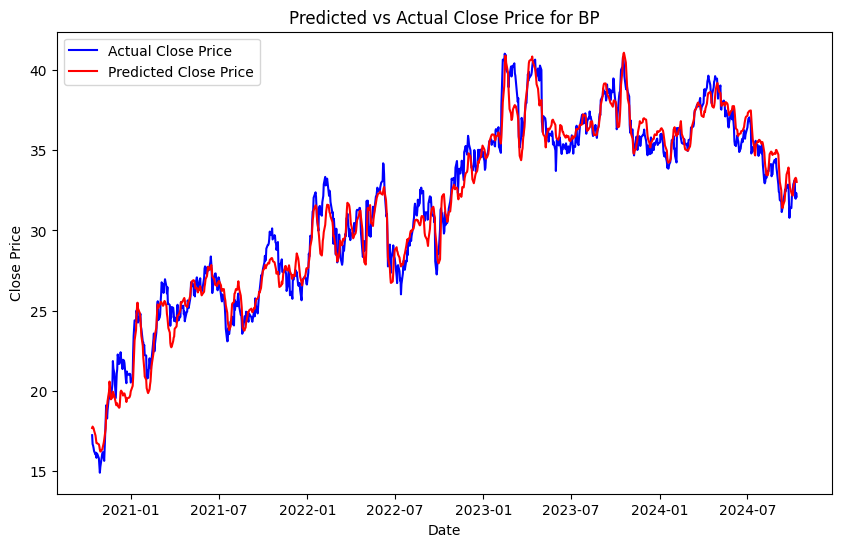

Mean Absolute Error for BP: 0.7765258743396118
           date  predicted value
0    2020-10-12        17.684410
1    2020-10-13        17.776400
2    2020-10-14        17.716089
3    2020-10-15        17.673011
4    2020-10-16        17.537346
...         ...              ...
1002 2024-10-07        33.197493
1003 2024-10-08        33.250923
1004 2024-10-09        33.283923
1005 2024-10-10        33.218128
1006 2024-10-11        33.026718

[1007 rows x 2 columns]

Processing stock: CVX
Order 1 AIC: 10224.867550550442
Order 2 AIC: 10220.12876142095
Order 3 AIC: 10219.291266747416
Order 4 AIC: 10214.214061326313
Order 5 AIC: 10212.68645269073

Optimal order for CVX: 5 with AIC: 10212.68645269073


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

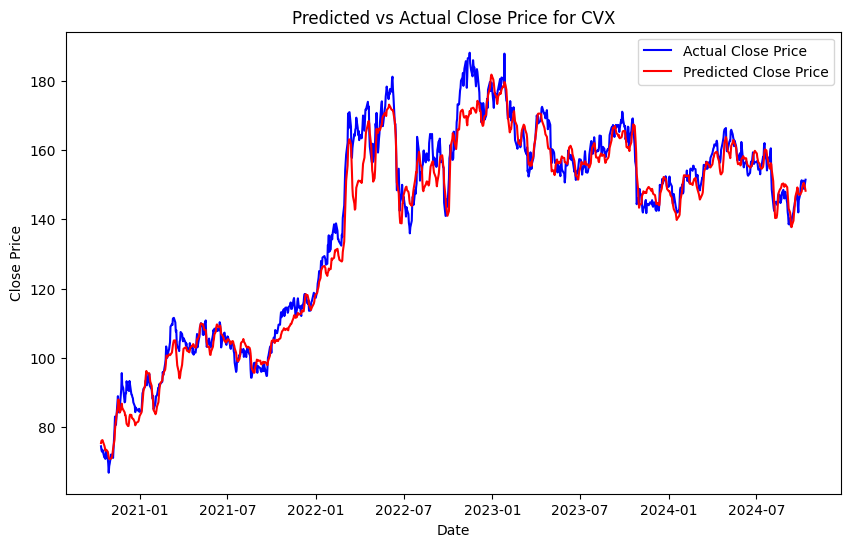

Mean Absolute Error for CVX: 3.536926081925199
           date  predicted value
0    2020-10-12        75.447117
1    2020-10-13        76.102304
2    2020-10-14        76.085700
3    2020-10-15        76.289740
4    2020-10-16        75.872941
...         ...              ...
1002 2024-10-07       150.527588
1003 2024-10-08       150.207551
1004 2024-10-09       149.723566
1005 2024-10-10       148.960321
1006 2024-10-11       148.227463

[1007 rows x 2 columns]

Processing stock: EQNR
Order 1 AIC: 2719.4559788859683
Order 2 AIC: 2715.8132018133665
Order 3 AIC: 2715.7399414238107
Order 4 AIC: 2714.156858006014
Order 5 AIC: 2713.8378711891805

Optimal order for EQNR: 5 with AIC: 2713.8378711891805


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

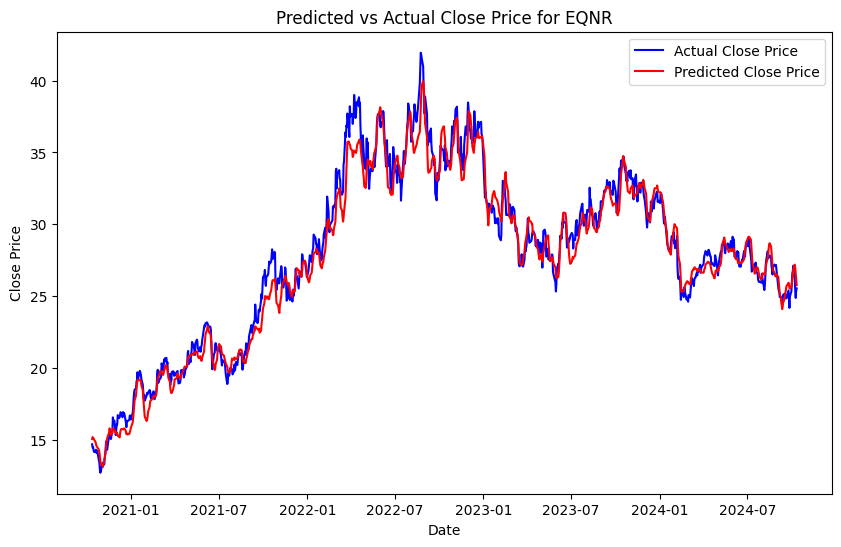

Mean Absolute Error for EQNR: 0.789461651446534
           date  predicted value
0    2020-10-12        15.069053
1    2020-10-13        15.199836
2    2020-10-14        15.151083
3    2020-10-15        15.111276
4    2020-10-16        15.022865
...         ...              ...
1002 2024-10-07        27.197346
1003 2024-10-08        26.988018
1004 2024-10-09        26.582610
1005 2024-10-10        26.212730
1006 2024-10-11        25.777570

[1007 rows x 2 columns]

Processing stock: OXY
Order 1 AIC: 9180.292612547664
Order 2 AIC: 9176.588827537424
Order 3 AIC: 9171.491648957526
Order 4 AIC: 9170.214018418254
Order 5 AIC: 9166.785328287991

Optimal order for OXY: 5 with AIC: 9166.785328287991


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

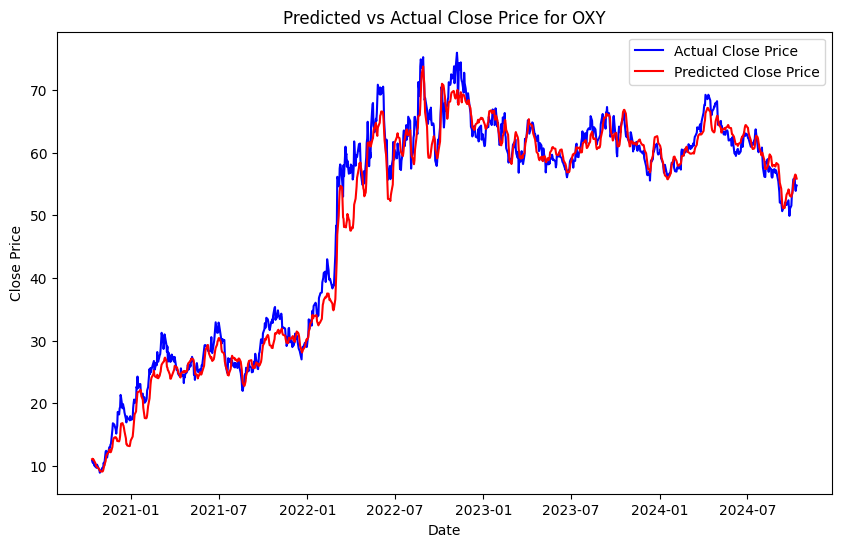

Mean Absolute Error for OXY: 1.844025937088029
           date  predicted value
0    2020-10-12        11.055993
1    2020-10-13        11.115413
2    2020-10-14        10.969373
3    2020-10-15        10.985651
4    2020-10-16        10.814008
...         ...              ...
1002 2024-10-07        56.262995
1003 2024-10-08        56.506634
1004 2024-10-09        56.452913
1005 2024-10-10        56.129351
1006 2024-10-11        55.859232

[1007 rows x 2 columns]

Processing stock: SHEL
Order 1 AIC: 7201.9386975595
Order 2 AIC: 7202.99651406524
Order 3 AIC: 7202.974026145871
Order 4 AIC: 7201.031847825281
Order 5 AIC: 7199.136354522115

Optimal order for SHEL: 5 with AIC: 7199.136354522115


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

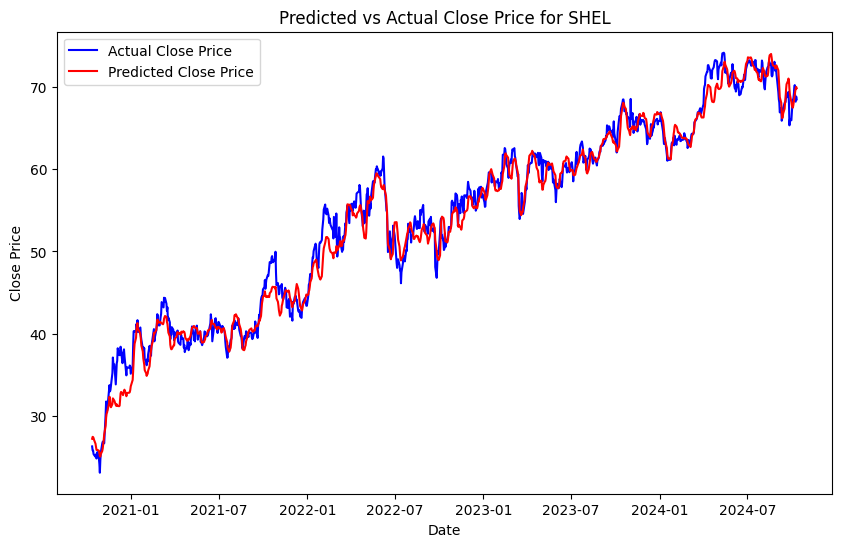

Mean Absolute Error for SHEL: 1.2463169923641033
           date  predicted value
0    2020-10-12        27.228474
1    2020-10-13        27.465355
2    2020-10-14        27.431887
3    2020-10-15        27.308907
4    2020-10-16        27.092866
...         ...              ...
1002 2024-10-07        69.093561
1003 2024-10-08        69.483615
1004 2024-10-09        69.821542
1005 2024-10-10        70.017460
1006 2024-10-11        69.847011

[1007 rows x 2 columns]

Processing stock: XOM
Order 1 AIC: 7714.452654037693
Order 2 AIC: 7711.523973821781
Order 3 AIC: 7709.862731765394
Order 4 AIC: 7704.661717241585
Order 5 AIC: 7703.163112209772

Optimal order for XOM: 5 with AIC: 7703.163112209772


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

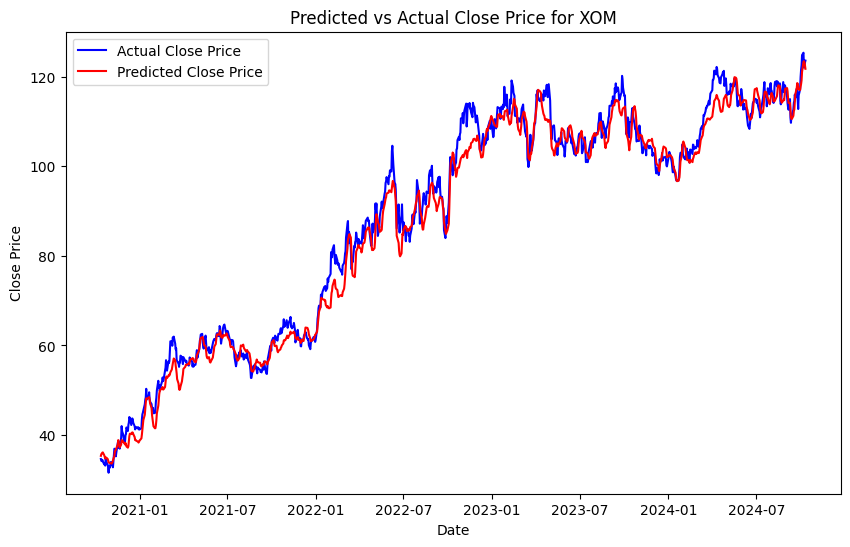

Mean Absolute Error for XOM: 2.4894453373176306
           date  predicted value
0    2020-10-12        35.345564
1    2020-10-13        35.748592
2    2020-10-14        35.833354
3    2020-10-15        36.061089
4    2020-10-16        36.105946
...         ...              ...
1002 2024-10-07       123.331984
1003 2024-10-08       123.462024
1004 2024-10-09       123.215997
1005 2024-10-10       122.586580
1006 2024-10-11       121.782034

[1007 rows x 2 columns]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ARDL
from sklearn.metrics import mean_absolute_error

# Load data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Filter out specific symbols
filtered_train_data = train_data[~train_data['symbol'].isin(['CL1', 'NG1'])]
filtered_test_data = test_data[~test_data['symbol'].isin(['CL1', 'NG1'])]

# Pivot the data to get the close prices in a time series format
train_df = filtered_train_data.pivot(index='date', columns='symbol', values='close')
train_df.index = pd.to_datetime(train_df.index)
test_df = filtered_test_data.pivot(index='date', columns='symbol', values='close')
test_df.index = pd.to_datetime(test_df.index)

symbols = train_df.columns.unique()

# Function to find the optimal order for exogenous variables
def find_optimal_order(symbol, train_endog, train_exog, max_order=5):
    min_aic = np.inf
    best_order = None
    best_model = None

    for order in range(1, max_order + 1):
        try:
            train_exog_lagged = train_exog.shift(order).dropna()
            train_endog_aligned = train_endog.iloc[-len(train_exog_lagged):].reset_index(drop=True)
            train_exog_aligned = train_exog_lagged.reset_index(drop=True)

            ardl_model = ARDL(train_endog_aligned, lags=1, exog=train_exog_aligned, trend='c')
            model_fit = ardl_model.fit()

            aic = model_fit.aic
            print(f"Order {order} AIC: {aic}")

            if aic < min_aic:
                min_aic = aic
                best_order = order
                best_model = model_fit
        except Exception as e:
            print(f"Could not fit model for order {order}: {e}")

    print(f"\nOptimal order for {symbol}: {best_order} with AIC: {min_aic}")
    return best_order

# Iterate over each stock symbol to train and test on the original scale
for symbol in symbols:
    print(f"\nProcessing stock: {symbol}")

    # Training data
    train_endog = train_df[symbol].dropna()
    train_exog = filtered_train_data[filtered_train_data['symbol'] == symbol][['momentum', '30day_STD','30day_SMA']].dropna()

    # Find the optimal order for exogenous variables
    optimal_order = find_optimal_order(symbol, train_endog, train_exog)

    # Testing data
    test_endog = test_df[symbol].dropna()
    test_exog = filtered_test_data[filtered_test_data['symbol'] == symbol][['momentum', '30day_STD','30day_SMA']].dropna()

    # Initialize history for rolling prediction
    history_endog = list(train_endog)
    history_exog = train_exog.values.tolist()
    predictions = []
    dates = list(test_endog.index)

    for t in range(len(test_endog)):
        # Fit ARDL model using the optimal exogenous order
        ardl_model = ARDL(history_endog, lags=1, exog=history_exog, trend='c')
        model_fit = ardl_model.fit()

        # Prepare the current exogenous variable for forecasting
        current_exog = test_exog.iloc[t].values.reshape(1, -1)
        forecast = model_fit.forecast(steps=1, exog=current_exog)[0]

        # Append the forecast to the predictions list
        predictions.append(forecast)

        # Update history with the forecasted value and current exogenous variables
        history_endog.append(forecast)
        history_exog.append(current_exog[0])

    # Create a DataFrame for the predictions
    predicted_df = pd.DataFrame({'date': dates, 'predicted value': predictions})

    # Save the DataFrame as a CSV file
    #csv_filename = f'3_variables_predicted_{symbol}.csv'
    #predicted_df.to_csv(csv_filename, index=False)

    # Download the CSV file
    #files.download(csv_filename)

    # Plot the actual vs. predicted close prices
    plt.figure(figsize=(10, 6))
    plt.plot(test_endog.index, test_endog, label='Actual Close Price', color='blue')
    plt.plot(test_endog.index, predictions, label='Predicted Close Price', color='red')
    plt.title(f'Predicted vs Actual Close Price for {symbol}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    # Calculate and print the Mean Absolute Error (MAE)
    mae = mean_absolute_error(test_endog, predictions)
    print(f"Mean Absolute Error for {symbol}: {mae}")

    # Print the predicted DataFrame
    print(predicted_df)


Step 3: Training and Testing using covariates: 'momentum', '7day_STD'


Processing stock: BP
Order 1 AIC: 5577.680634239113
Order 2 AIC: 5568.201327371993
Order 3 AIC: 5572.248263066367
Order 4 AIC: 5572.204946976138
Order 5 AIC: 5569.762690725163

Optimal order for BP: 2 with AIC: 5568.201327371993


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

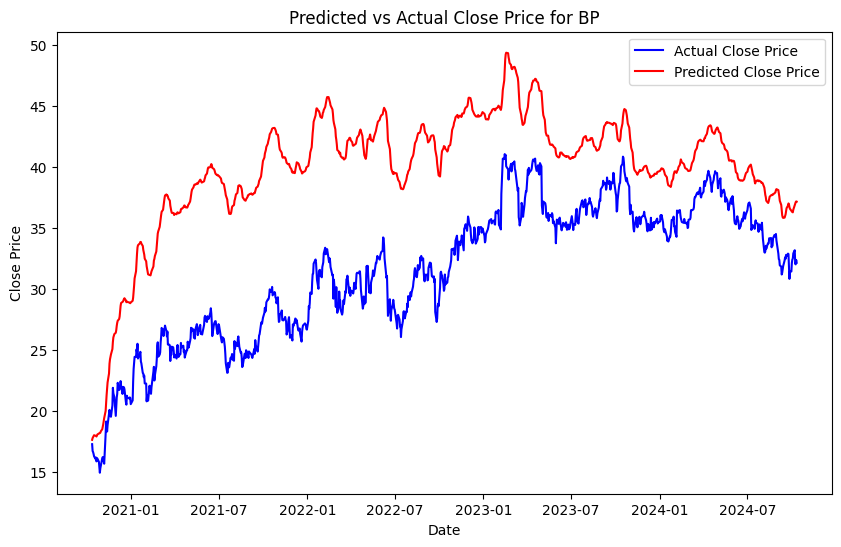

Mean Absolute Error for BP: 8.380853989857563
           date  predicted value
0    2020-10-12        17.595830
1    2020-10-13        17.742451
2    2020-10-14        17.823496
3    2020-10-15        17.921297
4    2020-10-16        17.975262
...         ...              ...
1002 2024-10-07        36.846085
1003 2024-10-08        36.964623
1004 2024-10-09        37.077842
1005 2024-10-10        37.138485
1006 2024-10-11        37.121645

[1007 rows x 2 columns]

Processing stock: CVX
Order 1 AIC: 10225.752336839565
Order 2 AIC: 10222.341484974519
Order 3 AIC: 10218.94364338301
Order 4 AIC: 10215.834553582981
Order 5 AIC: 10214.022154435845

Optimal order for CVX: 5 with AIC: 10214.022154435845


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

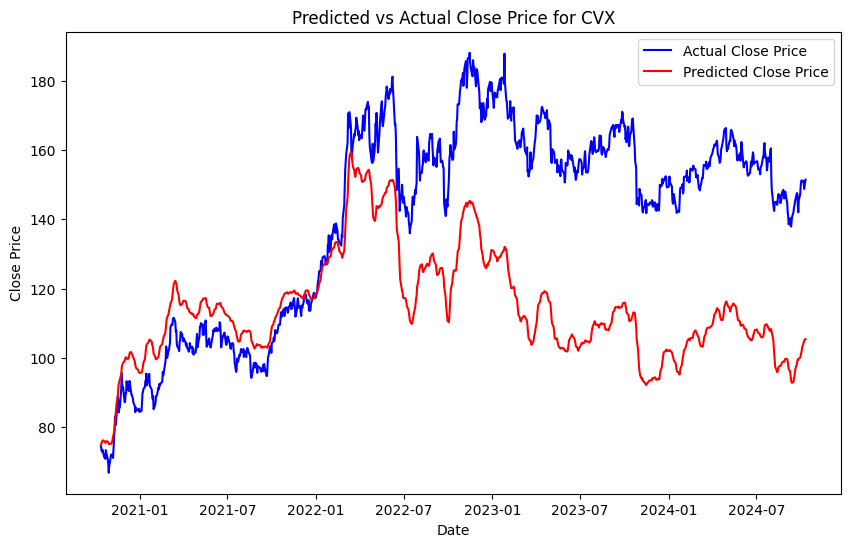

Mean Absolute Error for CVX: 30.33484300750529
           date  predicted value
0    2020-10-12        74.855840
1    2020-10-13        75.425283
2    2020-10-14        75.706824
3    2020-10-15        76.119556
4    2020-10-16        76.228441
...         ...              ...
1002 2024-10-07       104.404836
1003 2024-10-08       104.888950
1004 2024-10-09       105.230218
1005 2024-10-10       105.357558
1006 2024-10-11       105.420324

[1007 rows x 2 columns]

Processing stock: EQNR
Order 1 AIC: 2718.4232900403917
Order 2 AIC: 2715.377024436459
Order 3 AIC: 2714.6415315509653
Order 4 AIC: 2712.9649721415562
Order 5 AIC: 2713.2985288560417

Optimal order for EQNR: 4 with AIC: 2712.9649721415562


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

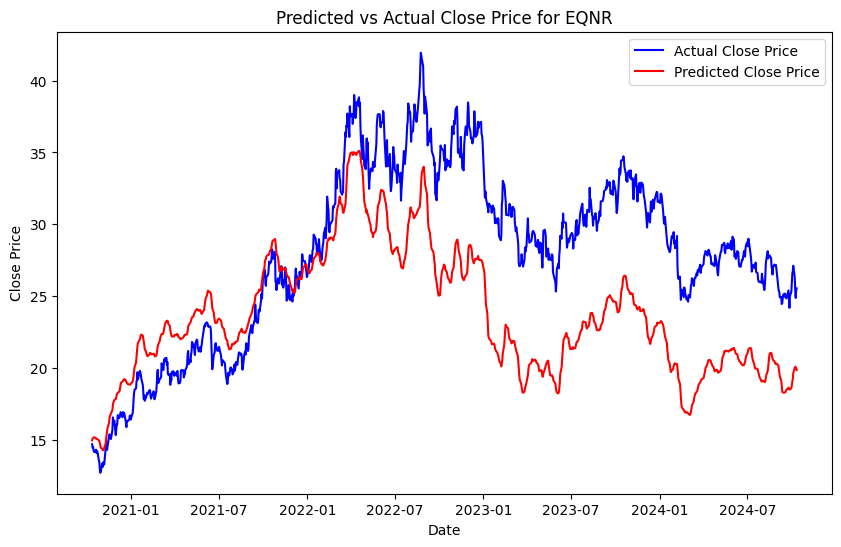

Mean Absolute Error for EQNR: 5.377589374583214
           date  predicted value
0    2020-10-12        14.973021
1    2020-10-13        15.093912
2    2020-10-14        15.129412
3    2020-10-15        15.169108
4    2020-10-16        15.182721
...         ...              ...
1002 2024-10-07        20.014826
1003 2024-10-08        20.095239
1004 2024-10-09        20.052305
1005 2024-10-10        19.993286
1006 2024-10-11        19.861624

[1007 rows x 2 columns]

Processing stock: OXY
Order 1 AIC: 9178.008484741338
Order 2 AIC: 9173.57810681174
Order 3 AIC: 9169.759040090652
Order 4 AIC: 9169.428639130354
Order 5 AIC: 9164.732087910137

Optimal order for OXY: 5 with AIC: 9164.732087910137


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

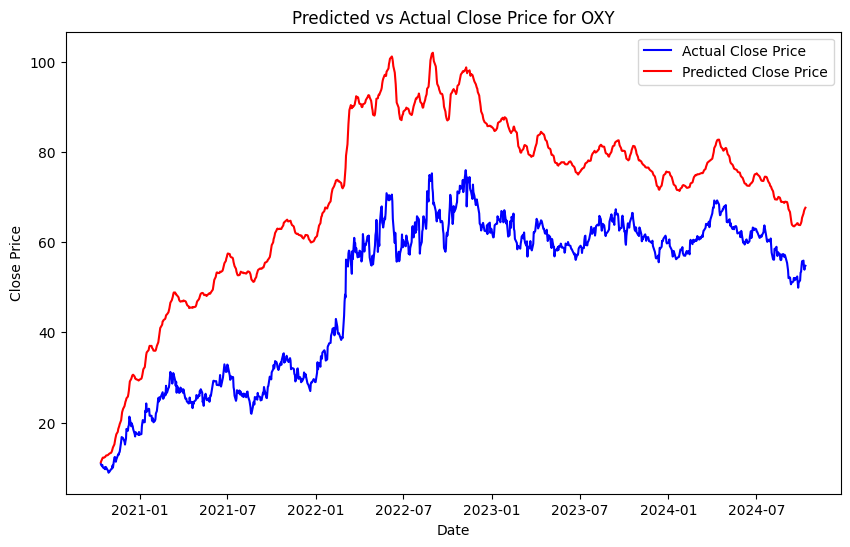

Mean Absolute Error for OXY: 20.847467495407372
           date  predicted value
0    2020-10-12        11.212675
1    2020-10-13        11.530452
2    2020-10-14        11.742284
3    2020-10-15        12.031325
4    2020-10-16        12.221543
...         ...              ...
1002 2024-10-07        66.341869
1003 2024-10-08        66.862267
1004 2024-10-09        67.230960
1005 2024-10-10        67.440891
1006 2024-10-11        67.645416

[1007 rows x 2 columns]

Processing stock: SHEL
Order 1 AIC: 7207.135599998522
Order 2 AIC: 7204.387006742152
Order 3 AIC: 7200.653378660873
Order 4 AIC: 7198.429517622707
Order 5 AIC: 7197.668286198758

Optimal order for SHEL: 5 with AIC: 7197.668286198758


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

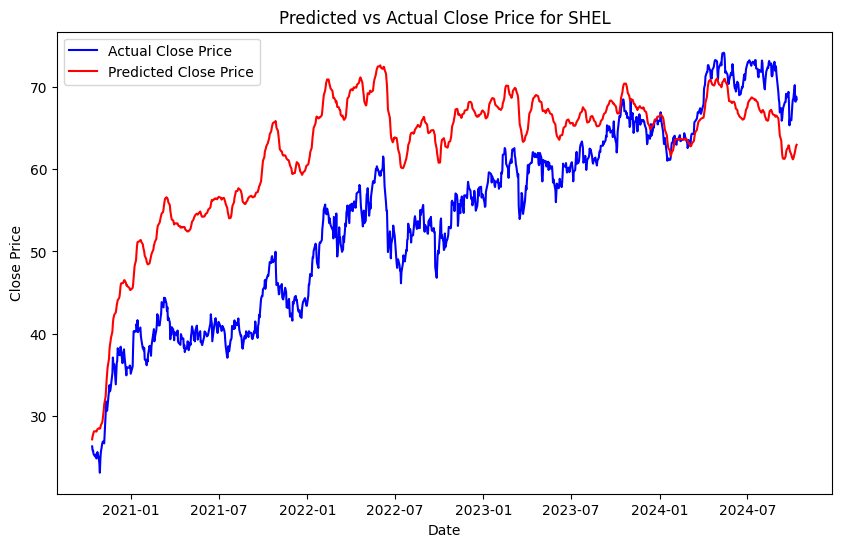

Mean Absolute Error for SHEL: 9.135401713033001
           date  predicted value
0    2020-10-12        27.158774
1    2020-10-13        27.530163
2    2020-10-14        27.778795
3    2020-10-15        27.981457
4    2020-10-16        28.128836
...         ...              ...
1002 2024-10-07        61.993943
1003 2024-10-08        62.306870
1004 2024-10-09        62.624999
1005 2024-10-10        62.892921
1006 2024-10-11        62.972493

[1007 rows x 2 columns]

Processing stock: XOM
Order 1 AIC: 7708.145345957321
Order 2 AIC: 7708.423939101615
Order 3 AIC: 7707.9433415551775
Order 4 AIC: 7704.446521862688
Order 5 AIC: 7702.457832413227

Optimal order for XOM: 5 with AIC: 7702.457832413227


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

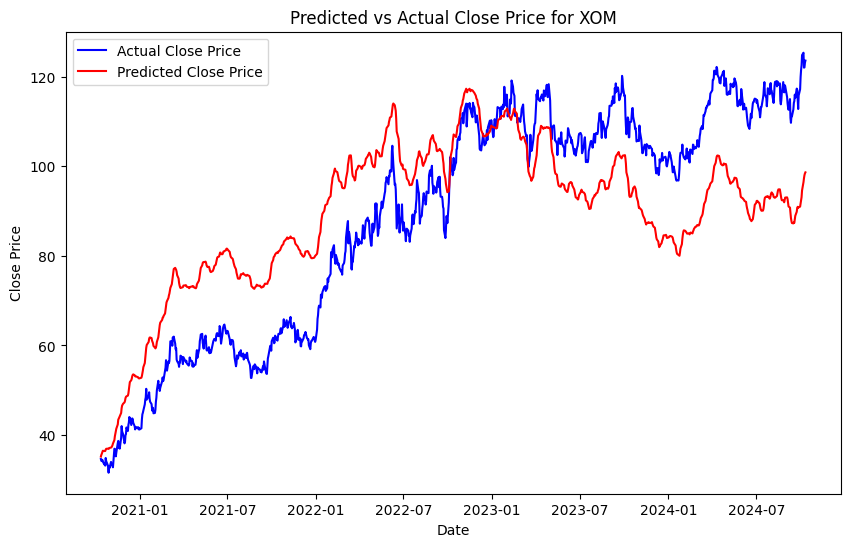

Mean Absolute Error for XOM: 14.101205682794726
           date  predicted value
0    2020-10-12        35.175604
1    2020-10-13        35.567312
2    2020-10-14        35.833210
3    2020-10-15        36.191561
4    2020-10-16        36.476720
...         ...              ...
1002 2024-10-07        96.469553
1003 2024-10-08        97.356862
1004 2024-10-09        98.018693
1005 2024-10-10        98.421250
1006 2024-10-11        98.651732

[1007 rows x 2 columns]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ARDL
from sklearn.metrics import mean_absolute_error
from google.colab import files  # Import the files module

# Load data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Filter out specific symbols
filtered_train_data = train_data[~train_data['symbol'].isin(['CL1', 'NG1'])]
filtered_test_data = test_data[~test_data['symbol'].isin(['CL1', 'NG1'])]

# Pivot the data to get the close prices in a time series format
train_df = filtered_train_data.pivot(index='date', columns='symbol', values='close')
train_df.index = pd.to_datetime(train_df.index)
test_df = filtered_test_data.pivot(index='date', columns='symbol', values='close')
test_df.index = pd.to_datetime(test_df.index)

symbols = train_df.columns.unique()

# Function to find the optimal order for exogenous variables
def find_optimal_order(symbol, train_endog, train_exog, max_order=5):
    min_aic = np.inf
    best_order = None
    best_model = None

    for order in range(1, max_order + 1):
        try:
            train_exog_lagged = train_exog.shift(order).dropna()
            train_endog_aligned = train_endog.iloc[-len(train_exog_lagged):].reset_index(drop=True)
            train_exog_aligned = train_exog_lagged.reset_index(drop=True)

            ardl_model = ARDL(train_endog_aligned, lags=1, exog=train_exog_aligned, trend='c')
            model_fit = ardl_model.fit()

            aic = model_fit.aic
            print(f"Order {order} AIC: {aic}")

            if aic < min_aic:
                min_aic = aic
                best_order = order
                best_model = model_fit
        except Exception as e:
            print(f"Could not fit model for order {order}: {e}")

    print(f"\nOptimal order for {symbol}: {best_order} with AIC: {min_aic}")
    return best_order

# Iterate over each stock symbol to train and test on the original scale
for symbol in symbols:
    print(f"\nProcessing stock: {symbol}")

    # Training data
    train_endog = train_df[symbol].dropna()
    train_exog = filtered_train_data[filtered_train_data['symbol'] == symbol][['momentum', '7day_STD']].dropna()

    # Find the optimal order for exogenous variables
    optimal_order = find_optimal_order(symbol, train_endog, train_exog)

    # Testing data
    test_endog = test_df[symbol].dropna()
    test_exog = filtered_test_data[filtered_test_data['symbol'] == symbol][['momentum', '7day_STD']].dropna()

    # Initialize history for rolling prediction
    history_endog = list(train_endog)
    history_exog = train_exog.values.tolist()
    predictions = []
    dates = list(test_endog.index)

    for t in range(len(test_endog)):
        # Fit ARDL model using the optimal exogenous order
        ardl_model = ARDL(history_endog, lags=1, exog=history_exog, trend='c')
        model_fit = ardl_model.fit()

        # Prepare the current exogenous variable for forecasting
        current_exog = test_exog.iloc[t].values.reshape(1, -1)
        forecast = model_fit.forecast(steps=1, exog=current_exog)[0]

        # Append the forecast to the predictions list
        predictions.append(forecast)

        # Update history with the forecasted value and current exogenous variables
        history_endog.append(forecast)
        history_exog.append(current_exog[0])

    # Create a DataFrame for the predictions
    predicted_df = pd.DataFrame({'date': dates, 'predicted value': predictions})

    # Save the DataFrame as a CSV file
    #csv_filename = f'2_variables_predicted_{symbol}.csv'
    #predicted_df.to_csv(csv_filename, index=False)

    # Download the CSV file
    #files.download(csv_filename)

    # Plot the actual vs. predicted close prices
    plt.figure(figsize=(10, 6))
    plt.plot(test_endog.index, test_endog, label='Actual Close Price', color='blue')
    plt.plot(test_endog.index, predictions, label='Predicted Close Price', color='red')
    plt.title(f'Predicted vs Actual Close Price for {symbol}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    # Calculate and print the Mean Absolute Error (MAE)
    mae = mean_absolute_error(test_endog, predictions)
    print(f"Mean Absolute Error for {symbol}: {mae}")

    # Print the predicted DataFrame
    print(predicted_df)
